In [ ]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import re
import os
import json
import math
from matplotlib.patches import Patch
import matplotlib.pyplot as plt

In [3]:
with open('CAGE_peak_to_nearest_gene.json', 'r') as f:
    dict_CAGE_peak_to_nearest = json.load(f)

In [4]:

folder_path = "./data/AML/P"
abundance_matrix = pd.DataFrame()
file_list = [f for f in os.listdir(folder_path) if f.endswith(".txt")]

for file in tqdm(file_list):
    full_path = os.path.join(folder_path, file)
    try:
        df = pd.read_csv(full_path, sep="\t")
        df["nearest_gene"] = df["CAGE_peak"].map(dict_CAGE_peak_to_nearest)
        df_max = df.groupby("nearest_gene", as_index=False)[df.columns[-2]].max()
        df_max.set_index(df_max.columns[0], inplace=True)
        abundance_matrix = pd.concat([abundance_matrix, df_max], axis=1)
    except Exception as e:
        print(f"load error:{file},information:{e}")

100%|██████████| 12/12 [00:01<00:00,  6.68it/s]


In [8]:
num_all_zero_rows = (abundance_matrix == 0).all(axis=1).sum()
print(abundance_matrix.shape[0]-num_all_zero_rows)

25602


In [9]:
abundance_matrix.to_csv(folder_path+"/abundance_matrix.csv")

In [10]:
gct = abundance_matrix[~(abundance_matrix == 0).all(axis=1)].copy()
gct.insert(0, "Description", "NA")

num_genes, num_samples = gct.shape[0], gct.shape[1] - 1 
header_lines = ["#1.2", f"{num_genes}\t{num_samples}"]
with open(folder_path+"/abundance_matrix.gct", 'w') as f:
    for line in header_lines:
        f.write(line + "\n")
    gct.to_csv(f, sep="\t")


In [11]:
#### label.cls prepration ####
label_series = ["sensitive" if "sensitive" in col else "resistant" for col in abundance_matrix.columns] 
for i in label_series:
    print(i, end=" ")

sensitive sensitive sensitive sensitive resistant sensitive sensitive sensitive resistant sensitive resistant sensitive 

In [119]:
report.columns

Index(['GS<br> follow link to MSigDB', 'GS DETAILS', 'SIZE', 'ES', 'NES',
       'NOM p-val', 'FDR q-val', 'FWER p-val', 'RANK AT MAX', 'LEADING EDGE',
       'Unnamed: 11'],
      dtype='object')

In [190]:
def clean_name_regex(name):
    name = re.sub(r'^[^_]+_', '', name) 
    name = re.sub(r'_PATHWAY$', '', name, flags=re.IGNORECASE)  
    return name
report_path = 'c:/Users/abdul/gsea_home/output/apr03/my_analysis.Gsea.1743654860767-CP/'

network_data = pd.DataFrame()
for group in ['resistant','sensitive']:
    group_data = pd.DataFrame()
    report = pd.read_csv(report_path+'gsea_report_for_'+group+'_1743654860767.tsv',sep='\t',index_col=0)
    for pathway_name in  report[(report['NOM p-val'] < 0.05) & (report['GS DETAILS'].notna())].index:
        pathway_path = report_path+str(pathway_name)+'.tsv'
        pathway_data = pd.read_csv(pathway_path,sep='\t',index_col=0)
        pathway_data = pathway_data[pathway_data['CORE ENRICHMENT']=='Yes']
        pathway_data.insert(0,'pathway', clean_name_regex(pathway_name))
        pathway_data.insert(len(pathway_data.columns),'NES', report.loc[pathway_name,'NES'])
        pathway_data.insert(len(pathway_data.columns),'p-val', report.loc[pathway_name,'NOM p-val'])
        group_data = pd.concat([group_data,pathway_data],axis=0)
    group_data.insert(0,'group', group)
    network_data = pd.concat([network_data,group_data],axis=0)
    # break


In [150]:
df.head()

,group,pathway,SYMBOL,TITLE,RANK IN GENE LIST,RANK METRIC SCORE,RUNNING ES,CORE ENRICHMENT,Unnamed: 7,NES,p-val
NAME,,,,,,,,,,,
row_16,resistant,RECYCLING_PATHWAY_OF_L1,CLTA,NaN,24318,-0.246212,-0.567046,Yes,NaN,-1.930911,0.0
row_17,resistant,RECYCLING_PATHWAY_OF_L1,RPS6KA2,NaN,24495,-0.255639,-0.524926,Yes,NaN,-1.930911,0.0
row_18,resistant,RECYCLING_PATHWAY_OF_L1,ACTB,NaN,24509,-0.256265,-0.476598,Yes,NaN,-1.930911,0.0
row_19,resistant,RECYCLING_PATHWAY_OF_L1,RPS6KA1,NaN,25303,-0.301508,-0.448784,Yes,NaN,-1.930911,0.0
row_20,resistant,RECYCLING_PATHWAY_OF_L1,TUBA4B,NaN,26185,-0.391784,-0.407062,Yes,NaN,-1.930911,0.0


In [ ]:
#### line view ####
df = network_data

pathway_groups = df.groupby('pathway')

num_pathways = len(pathway_groups)
fig, axes = plt.subplots(1, num_pathways, figsize=(5*num_pathways, 5))

if num_pathways == 1:
    axes = [axes]

color_map = {'resistant': 'red', 'sensitive': 'blue'}

for ax, (pathway, group_df) in zip(axes, pathway_groups):
    G = nx.Graph()
    symbols = group_df['SYMBOL'].tolist()
    
    for idx, row in group_df.iterrows():
        G.add_node(
            row['SYMBOL'],
            group=row['group'],
            NES=row['NES']
        )

    for i in range(len(symbols)):
        for j in range(i+1, len(symbols)):
            G.add_edge(symbols[i], symbols[j])
    
    pos = nx.spring_layout(G, seed=42)
    node_colors = [color_map[G.nodes[node]['group']] for node in G.nodes]
    node_sizes = [abs(G.nodes[node]['NES']) * 300 for node in G.nodes]

    nx.draw_networkx_nodes(G, pos, ax=ax, node_color=node_colors, node_size=node_sizes, alpha=0.8)
    nx.draw_networkx_edges(G, pos, ax=ax, width=1.0, alpha=0.5)
    
    # nx.draw_networkx_labels(G, pos, ax=ax, font_size=8)

    ax.set_title(pathway, fontsize=12)
    ax.axis('off')

plt.tight_layout()
plt.show()


In [ ]:


df = network_data

pathway_groups = df.groupby('pathway')
num_pathways = len(pathway_groups)

ncols = 5
nrows = math.ceil(num_pathways / ncols)

fig, axes = plt.subplots(nrows, ncols, figsize=(5*ncols, 5*nrows))

axes = axes.flatten()

color_map = {'resistant': 'red', 'sensitive': 'blue'}

for ax, (pathway, group_df) in zip(axes, pathway_groups):
    G = nx.Graph()
    symbols = group_df['SYMBOL'].tolist()
    
    for idx, row in group_df.iterrows():
        G.add_node(
            row['SYMBOL'],
            group=row['group'],
            NES=row['NES']
        )

    for i in range(len(symbols)):
        for j in range(i+1, len(symbols)):
            G.add_edge(symbols[i], symbols[j])
    
    pos = nx.spring_layout(G, seed=42)
    node_colors = [color_map[G.nodes[node]['group']] for node in G.nodes]
    node_sizes = [abs(G.nodes[node]['NES']) * 300 for node in G.nodes]

    nx.draw_networkx_nodes(G, pos, ax=ax, node_color=node_colors, node_size=node_sizes, alpha=1)
    nx.draw_networkx_edges(G, pos, ax=ax, width=1.0, alpha=0.5)
    
    ax.set_title(pathway, fontsize=10)
    ax.axis('off')

for i in range(num_pathways, len(axes)):
    axes[i].axis('off')

legend_elements = [
    Patch(facecolor='red', label='Resistant'),
    Patch(facecolor='blue', label='Sensitive')
]

fig.legend(
    handles=legend_elements,
    loc='lower center',
    bbox_to_anchor=(0.5, -0.02), 
    ncol=2,
    fontsize=12,
    frameon=False
)

plt.tight_layout(rect=[0, 0.05, 1, 1])  
plt.show()


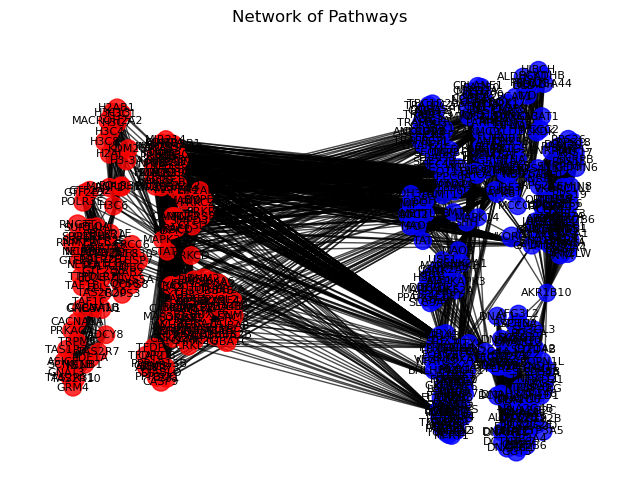

In [189]:

df = network_data
G = nx.Graph()

for idx, row in df.iterrows():
    G.add_node(
        row['SYMBOL'],
        group=row['group'],
        pathway=row['pathway'],
        NES=row['NES']
    )
pathway_groups = df.groupby('pathway')

for pathway, group_df in pathway_groups:
    symbols = group_df['SYMBOL'].tolist()
    for i in range(len(symbols)):
        for j in range(i+1, len(symbols)):
            G.add_edge(symbols[i], symbols[j])

color_map = {'resistant': 'red', 'sensitive': 'blue'}
node_colors = [color_map[G.nodes[node]['group']] for node in G.nodes]
node_sizes = [abs(G.nodes[node]['NES']) * 100 for node in G.nodes]
plt.figure(figsize=(8, 6))


group_to_nodes = {
    'resistant': [],
    'sensitive': []
}
for node in G.nodes:
    group = G.nodes[node]['group']
    group_to_nodes[group].append(node)
pos = {}

# resistant堆
resistant_pos = nx.spring_layout(G.subgraph(group_to_nodes['resistant']), seed=42, k=0.5)
for node, p in resistant_pos.items():
    pos[node] = (p[0] - 2, p[1])  # 左边移动2个单位

# sensitive堆
sensitive_pos = nx.spring_layout(G.subgraph(group_to_nodes['sensitive']), seed=42, k=0.5)
for node, p in sensitive_pos.items():
    pos[node] = (p[0] + 2, p[1])  

# pos = nx.spring_layout(G, seed=2025)  

nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=node_sizes, alpha=0.8)
nx.draw_networkx_edges(G, pos, width=1.0, alpha=0.7)
nx.draw_networkx_labels(G, pos, font_size=8)

plt.axis('off')
plt.title('Network of Pathways')
plt.show()


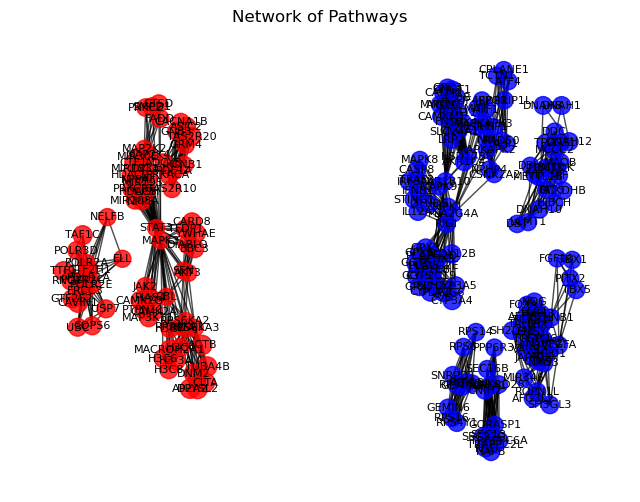

In [191]:

df = network_data
G = nx.Graph()

for idx, row in df.iterrows():
    G.add_node(
        row['SYMBOL'],
        group=row['group'],
        pathway=row['pathway'],
        NES=row['NES']
    )
pathway_groups = df.groupby('pathway')

for pathway, group_df in pathway_groups:
    symbols = group_df['SYMBOL'].tolist()
    for i in range(len(symbols)):
        for j in range(i+1, len(symbols)):
            G.add_edge(symbols[i], symbols[j])

color_map = {'resistant': 'red', 'sensitive': 'blue'}
node_colors = [color_map[G.nodes[node]['group']] for node in G.nodes]
node_sizes = [abs(G.nodes[node]['NES']) * 100 for node in G.nodes]
plt.figure(figsize=(8, 6))


group_to_nodes = {
    'resistant': [],
    'sensitive': []
}
for node in G.nodes:
    group = G.nodes[node]['group']
    group_to_nodes[group].append(node)
pos = {}

# resistant堆
resistant_pos = nx.spring_layout(G.subgraph(group_to_nodes['resistant']), seed=42, k=0.5)
for node, p in resistant_pos.items():
    pos[node] = (p[0] - 2, p[1])  # 左边移动2个单位

# sensitive堆
sensitive_pos = nx.spring_layout(G.subgraph(group_to_nodes['sensitive']), seed=42, k=0.5)
for node, p in sensitive_pos.items():
    pos[node] = (p[0] + 2, p[1])  

# pos = nx.spring_layout(G, seed=2025)  

nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=node_sizes, alpha=0.8)
nx.draw_networkx_edges(G, pos, width=1.0, alpha=0.7)
nx.draw_networkx_labels(G, pos, font_size=8)

plt.axis('off')
plt.title('Network of Pathways')
plt.show()


In [ ]:

G = nx.Graph()

for idx, row in df.iterrows():
    G.add_node(
        row['SYMBOL'],
        group=row['group'],
        pathway=row['pathway'],
        NES=row['NES']
    )

pathway_groups = df.groupby('pathway')

for pathway, group_df in pathway_groups:
    symbols = group_df['SYMBOL'].tolist()
    for i in range(len(symbols)):
        for j in range(i+1, len(symbols)):
            G.add_edge(symbols[i], symbols[j])

subgraphs = [G.subgraph(group_df['SYMBOL'].tolist()) for pathway, group_df in pathway_groups]

plt.figure(figsize=(16, 14))

pos = {}
x_offset = 0
y_offset = 0
gap = 5  

for i, sg in enumerate(subgraphs):
    sub_pos = nx.spring_layout(sg, seed=42)
    
    for node in sub_pos:
        pos[node] = (sub_pos[node][0] + x_offset, sub_pos[node][1] + y_offset)
    
    x_offset += gap
    if (i + 1) % 5 == 0: 
        x_offset = 0
        y_offset -= gap

color_map = {'resistant': 'red', 'sensitive': 'blue'}
node_colors = [color_map[G.nodes[node]['group']] for node in G.nodes]
node_sizes = [abs(G.nodes[node]['NES']) * 300 for node in G.nodes]

nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=node_sizes, alpha=0.8)
nx.draw_networkx_edges(G, pos, width=1.0, alpha=0.5)

for pathway, group_df in pathway_groups:
    symbols = group_df['SYMBOL'].tolist()
    symbol_pos = [pos[s] for s in symbols if s in pos]
    
    if symbol_pos:
        x = sum(p[0] for p in symbol_pos) / len(symbol_pos)
        y = sum(p[1] for p in symbol_pos) / len(symbol_pos)
        
        plt.text(
            x, y - 0.3,  
            pathway,
            horizontalalignment='center',
            fontsize=10,
            bbox=dict(facecolor='white', alpha=0.6, boxstyle='round,pad=0.2')
        )

legend_elements = [
    Patch(facecolor='red', label='Resistant'),
    Patch(facecolor='blue', label='Sensitive')
]
plt.legend(handles=legend_elements, loc='lower center', bbox_to_anchor=(0.5, -0.15), ncol=2, frameon=False)

plt.axis('off')
plt.tight_layout()
plt.show()


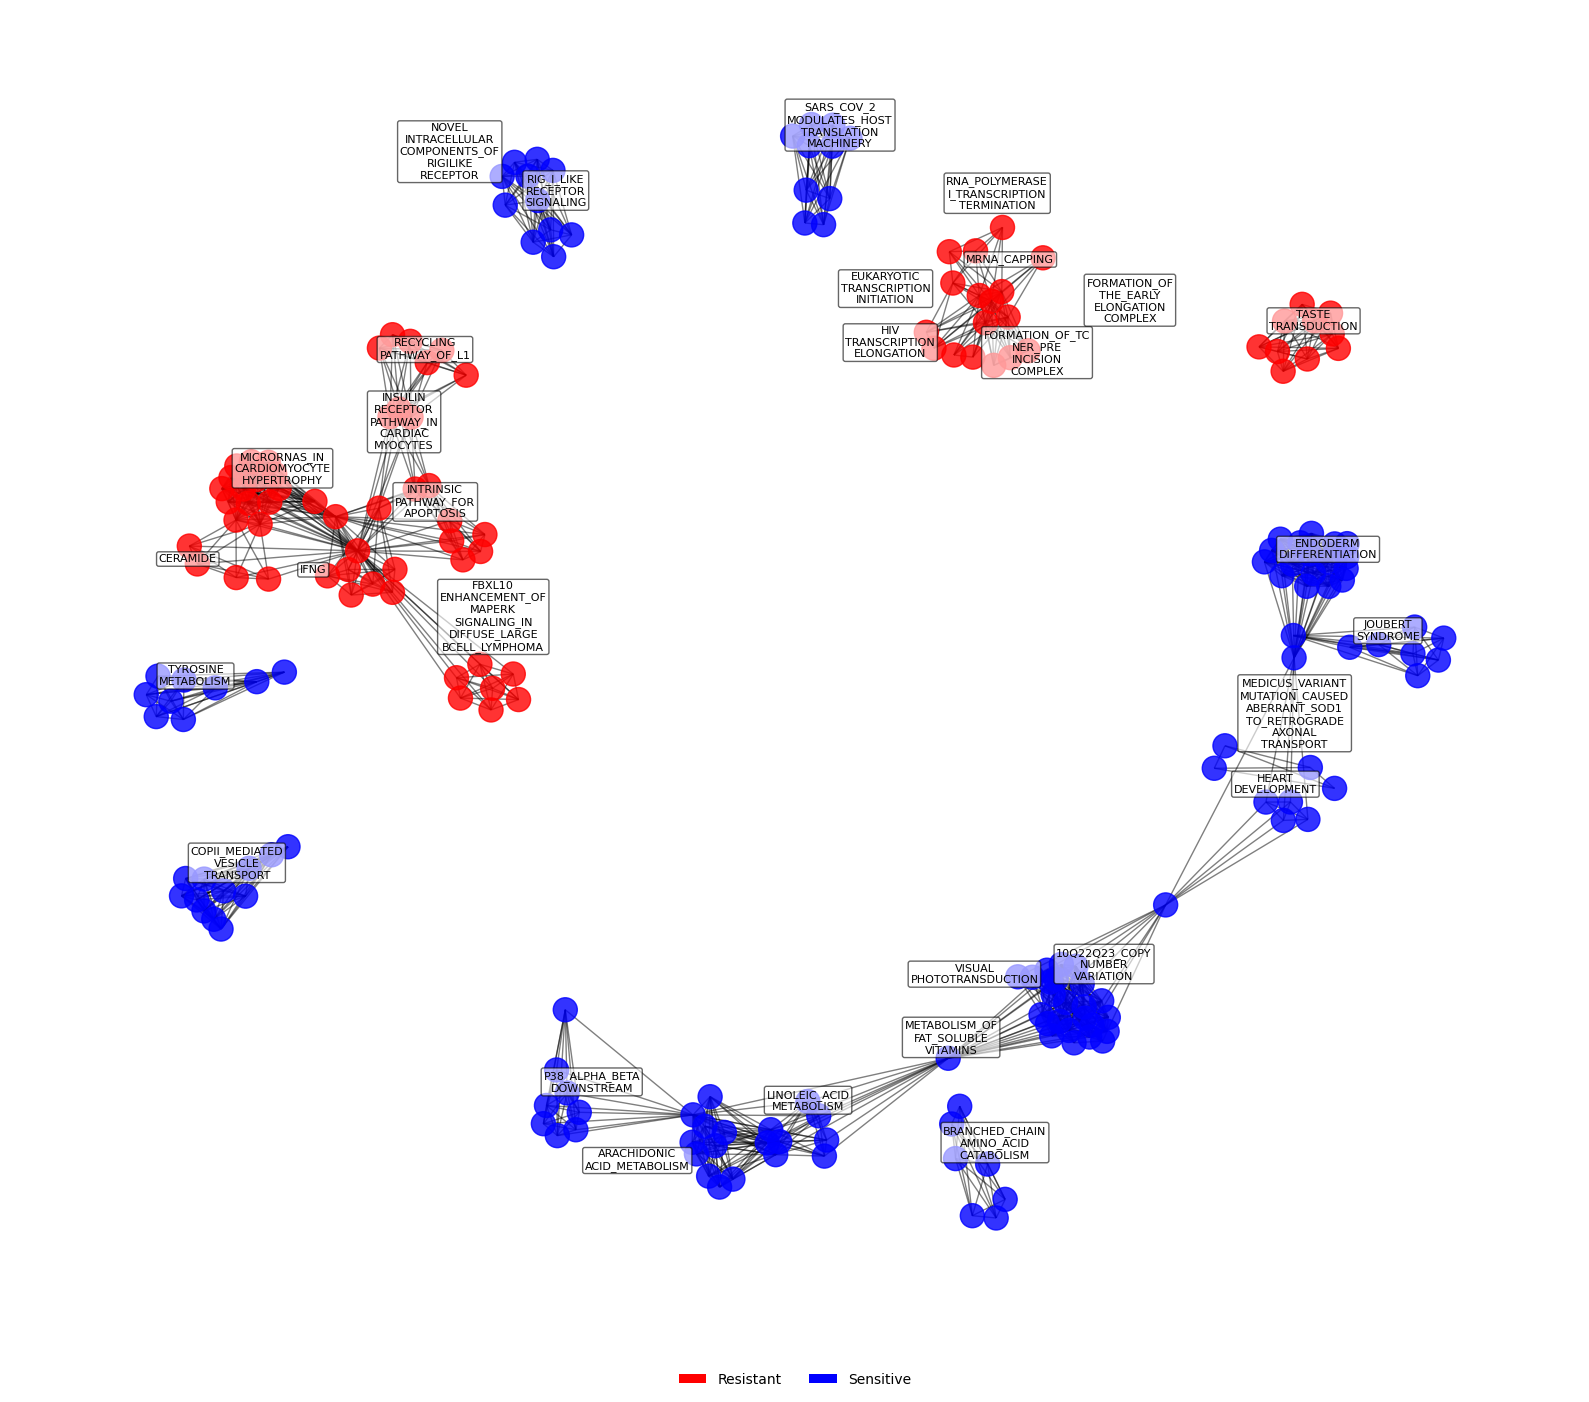

In [260]:
from adjustText import adjust_text


G = nx.Graph()

for idx, row in df.iterrows():
    G.add_node(
        row['SYMBOL'],
        group=row['group'],
        pathway=row['pathway'],
        NES=row['NES']
    )

pathway_groups = df.groupby('pathway')

for pathway, group_df in pathway_groups:
    symbols = group_df['SYMBOL'].tolist()
    for i in range(len(symbols)):
        for j in range(i+1, len(symbols)):
            G.add_edge(symbols[i], symbols[j])

plt.figure(figsize=(16, 14))

pos = nx.spring_layout(G, k=1.1, iterations=300, seed=0)  

color_map = {'resistant': 'red', 'sensitive': 'blue'}
node_colors = [color_map[G.nodes[node]['group']] for node in G.nodes]
# node_sizes = [abs(G.nodes[node]['NES']) * 200 for node in G.nodes]

nx.draw_networkx_nodes(G, pos, node_color=node_colors, alpha=0.8)
nx.draw_networkx_edges(G, pos, width=1.0, alpha=0.5)

def wrap_label(label, max_width):
    words = label.split('_') 
    new_label = ''
    line = ''
    for word in words:
        if len(line + word) <= max_width:
            line += word + '_'
        else:
            new_label += line.rstrip('_') + '\n'
            line = word + '_'
    new_label += line.rstrip('_')
    return new_label
texts = []
for pathway, group_df in pathway_groups:
    symbols = group_df['SYMBOL'].tolist()
    symbol_pos = [pos[s] for s in symbols if s in pos]
    
    if symbol_pos:
        x = sum(p[0] for p in symbol_pos) / len(symbol_pos)
        y = sum(p[1] for p in symbol_pos) / len(symbol_pos)
        
        text = plt.text(
            x-0.05, y,
            wrap_label(pathway, max_width=15),
            horizontalalignment='center',
            fontsize=8,
            bbox=dict(facecolor='white', alpha=0.6, boxstyle='round,pad=0.2')
        )
        texts.append(text)

adjust_text(texts, arrowprops=dict(arrowstyle='-', color='gray', lw=0.0))

legend_elements = [
    Patch(facecolor='red', label='Resistant'),
    Patch(facecolor='blue', label='Sensitive')
]
plt.legend(handles=legend_elements, loc='lower center', bbox_to_anchor=(0.5, -0.05), ncol=2, frameon=False)

plt.axis('off')
plt.tight_layout()
# plt.show()
plt.savefig('plot.pdf')


In [14]:
#### GSEA by gseapy
import gseapy as gp
phenoA, phenoB, class_vector =  gp.parser.gsea_cls_parser("./data/AML/invitro/labels.cls")

In [15]:
abundance_matrix = pd.read_csv("./data/AML/invitro/abundance_matrix.csv",index_col=0)
gene_exp = abundance_matrix[~(abundance_matrix == 0).all(axis=1)].copy()
gene_exp.insert(0, "Description", "NA")

In [17]:
# run gsea
# enrichr libraries are supported by gsea module. Just provide the name
gs_res = gp.gsea(data=gene_exp, # or data='./P53_resampling_data.txt'
                 gene_sets='c2.cp.kegg_medicus.v2024.1.Hs.symbols.gmt', # or enrichr library names
                 cls= "./data/AML/invitro/labels.cls", # cls=class_vector
                 # set permutation_type to phenotype if samples >=15
                 permutation_type='gene_set', 
                 permutation_num=1000, # reduce number to speed up test
                 outdir=None,  # do not write output to disk
                 method='signal_to_noise',
                 max_size=1000,
                 min_size=2,
                 threads=1, seed= 7)
gs_res.pheno_pos = phenoA
gs_res.pheno_neg = phenoB
gs_res.run()

In [ ]:
terms = gs_res.res2d.Term
axs = gs_res.plot(terms[:15], show_ranking=False, legend_kws={'loc': (1.05, 0)}, )

In [ ]:
from gseapy import heatmap
# plotting heatmap
i = 1
genes = gs_res.res2d.Lead_genes[i].split(";")
# Make sure that ``ofname`` is not None, if you want to save your figure to disk
ax = heatmap(df = gs_res.heatmat.loc[genes], z_score=0, title=terms[i], figsize=(14,4))

In [33]:
gs_res.heatmat.loc[genes]

,B01_AML_sensitive,B11_AML_sensitive,B12_AML_sensitive,B18_AML_sensitive,B19_AML_sensitive,B20_AML_sensitive,B22_AML_sensitive,P01_AML_sensitive,P02_AML_sensitive,P03_AML_sensitive,...,B02_AML_resistant,B03_AML_resistant,B04_AML_resistant,B05_AML_resistant,B07_AML_resistant,B13_AML_resistant,B15_AML_resistant,P05_AML_resistant,P09_AML_resistant,P12_AML_resistant
nearest_gene,,,,,,,,,,,,,,,,,,,,,
MAPK3,6.904063e+01,2.716430e+01,5.315878e+01,3.509301e+01,5.887542e+01,4.620912e+01,5.782829e+01,4.194881e+01,3.932759e+01,5.236366e+01,...,9.562852e+01,6.862404e+01,5.834844e+01,77.525720,1.235203e+02,7.464210e+01,5.365548e+01,3.315008e+01,2.390970e+01,6.854346e+01
CCND1,1.000000e-08,1.000000e-08,1.000000e-08,1.000000e-08,1.000000e-08,1.000000e-08,1.000000e-08,1.000000e-08,1.000000e-08,1.000000e-08,...,1.000000e-08,1.000000e-08,1.000000e-08,0.163902,1.000000e-08,1.000000e-08,1.000000e-08,1.000000e-08,1.000000e-08,1.000000e-08
MAP2K2,1.202981e+02,9.096159e+01,9.639111e+01,9.826042e+01,8.086209e+01,1.046289e+02,1.307627e+02,1.174828e+02,7.398919e+01,7.395485e+01,...,1.090572e+02,1.995839e+02,8.396482e+01,103.750065,9.805561e+01,1.284080e+02,1.029952e+02,7.452805e+01,9.955128e+01,8.594458e+01
HRAS,1.031126e+01,1.319409e+01,1.175501e+01,1.840433e+01,1.209267e+01,9.577019e+00,1.911874e+01,2.273861e+01,8.932028e+00,9.181298e+00,...,1.437819e+01,1.626745e+01,2.150511e+01,21.962889,1.405519e+01,1.506628e+01,1.726307e+01,8.347142e+00,6.738187e+00,1.167149e+01


In [ ]:
from gseapy import dotplot
import matplotlib.pyplot as plt

# to save your figure, make sure that ``ofname`` is not None
ax = dotplot(gs_res.res2d, 
             column="FDR q-val",
             title='KEGG_2021_Human',
             cmap=plt.cm.viridis, 
             size=5, 
             figsize=(4,5), cutoff=1)